In [45]:
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd

# Loading

In [27]:
TRAIN_PATH = "data/download/train.csv"
TEST_PATH = "data/download/test.csv"

In [28]:
# number of rows of train
!wc -l {TRAIN_PATH}

 55423856 data/download/train.csv


In [29]:
# number of rows of test
!wc -l {TEST_PATH}

    9914 data/download/test.csv


In [30]:
# let's read the first few rows
train_df = pd.read_csv(TRAIN_PATH, nrows=5)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
key                  5 non-null object
fare_amount          5 non-null float64
pickup_datetime      5 non-null object
pickup_longitude     5 non-null float64
pickup_latitude      5 non-null float64
dropoff_longitude    5 non-null float64
dropoff_latitude     5 non-null float64
passenger_count      5 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 400.0+ bytes


In [32]:
pd.to_datetime(train_df["key"])

0   2009-06-15 17:26:21.000000100
1   2010-01-05 16:52:16.000000200
2   2011-08-18 00:35:00.000000490
3   2012-04-21 04:30:42.000000100
4   2010-03-09 07:51:00.000000135
Name: key, dtype: datetime64[ns]

In [33]:
pd.to_datetime(train_df["pickup_datetime"])

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

Columns `key` and and `pickup_datetime` seem to be the same timestamp, except that `pickup_datetime` has second precision whereas `key` has nano second precision. Probably `key` is used to uniquely identify each row and hence not important for data analysis and modeling. We will drop this column in the train set. `key` is still needed for the test set to write out the Kaggle submission file.

`train.csv` has a large number of rows (more than 55 million) so it may take a long time to read it into a dataframe. To quickly read the data and reduce its size, we follow this post: https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows .

In [34]:
def load_nyc_taxi_fare(path, col_types, chunksize=None):
    chunk_iter = pd.read_csv(path, usecols=col_types.keys(), dtype=col_types, chunksize=chunksize)
    
    if chunksize is None:
        chunk_iter["pickup_datetime"] = pd.to_datetime(chunk_iter["pickup_datetime"], 
                                                       utc=True, format="%Y-%m-%d %H:%M:%S UTC")
        return chunk_iter
    
    df_list = []
    # use tqdm to monitor progress
    # It would take extremely long time if format were not used.
    for df_chunk in tqdm(chunk_iter):
        df_chunk["pickup_datetime"] = pd.to_datetime(df_chunk["pickup_datetime"], 
                                                     utc=True, format="%Y-%m-%d %H:%M:%S UTC")
        df_list.append(df_chunk)
    return pd.concat(df_list)

In [42]:
train_types = {"fare_amount": "float32",
              "pickup_datetime": "str", 
              "pickup_longitude": "float32",
              "pickup_latitude": "float32",
              "dropoff_longitude": "float32",
              "dropoff_latitude": "float32",
              "passenger_count": "uint8"}
train_df = load_nyc_taxi_fare(TRAIN_PATH, train_types, chunksize=5_000_000)
train_df.head()

12it [05:11, 20.56s/it]


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


In [36]:
train_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [37]:
test_types = train_types.copy()
test_types.pop("fare_amount")
test_types["key"] = "str"

test_df = load_nyc_taxi_fare(TEST_PATH, test_types)
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1


# Cleaning

In [38]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,8.077921e+00,-3.875290e+01,1.937328e+01,-3.875261e+01,1.937341e+01,1.685380e+00
std,2.055127e+01,2.556202e+01,1.414234e+01,2.553839e+01,1.412191e+01,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


In [39]:
print("Number of negative values of fare_amount: %d " % (train_df["fare_amount"] < 0).sum())

Number of negative values of fare_amount: 2454 


Since negative values of `fare_amount` do not make sense so we will drop them.

In [43]:
print("Shape before dropping:", train_df.shape)
train_df = train_df[train_df["fare_amount"] >= 0]
print("Shape after dropping:", train_df.shape)

Shape before dropping: (55423856, 7)
Shape after dropping: (55421402, 7)


Very large values of `fare_amount` may also be problematic. Let's look the histogram.

Text(0.5, 0, 'fare_amount')

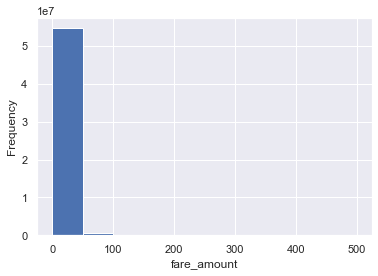

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
train_df["fare_amount"].plot(kind="hist", ax=ax)
ax.set_xlabel("fare_amount")

Text(0.5, 0, 'fare_amount')

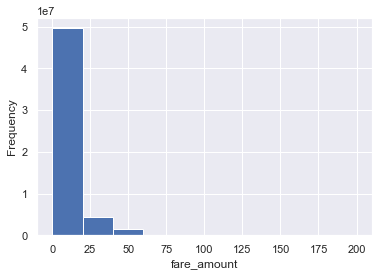

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
train_df.loc[train_df["fare_amount"] < 200, "fare_amount"].plot(kind="hist", ax=ax)
ax.set_xlabel("fare_amount")

In [54]:
for fare in [100, 200, 500, 1000, 5000, 10000]:
    print("Number of rows with fare_amount greater than %d: %d" %(fare, (train_df["fare_amount"] > fare).sum()))

Number of rows with fare_amount greater than 100: 20875
Number of rows with fare_amount greater than 200: 1654
Number of rows with fare_amount greater than 500: 43
Number of rows with fare_amount greater than 1000: 12
Number of rows with fare_amount greater than 5000: 4
Number of rows with fare_amount greater than 10000: 3


We decide to drop rows with `fare_amount` greater than $500.

In [55]:
print("Shape before dropping:", train_df.shape)
train_df = train_df[train_df["fare_amount"] <= 500]
print("Shape after dropping:", train_df.shape)

Shape before dropping: (55421402, 7)
Shape after dropping: (55421359, 7)


In [56]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542136e+07,5.542136e+07,5.542136e+07,5.542098e+07,5.542098e+07,5.542136e+07
mean,8.074207e+00,-3.875465e+01,1.937415e+01,-3.875436e+01,1.937428e+01,1.685369e+00
std,9.842649e+00,2.556260e+01,1.414266e+01,2.553896e+01,1.412201e+01,1.327657e+00
min,0.000000e+00,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,5.000000e+02,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


Latitude ranges from -90$^o$ to 90$^o$ and longitude from -180$^o$ to 180$^o$. Values outside these ranges do not make sense and we will drop them.

In [70]:
def drop_wrong_gps_coor(df):
    df = df[(df["pickup_longitude"] >= -180) & (df["pickup_longitude"] <= 180)]
    df = df[(df["dropoff_longitude"] >= -180) & (df["dropoff_longitude"] <= 180)]
    
    df = df[(df["pickup_latitude"] >= -90) & (df["pickup_latitude"] <= 90)]
    df = df[(df["dropoff_latitude"] >= -90) & (df["dropoff_latitude"] <= 90)]
    return df

In [71]:
print("Shape before dropping:", train_df.shape)
train_df = drop_wrong_gps_coor(train_df)
print("Shape before dropping:", train_df.shape)

Shape before dropping: (55421359, 7)
Shape before dropping: (55418238, 7)


In [72]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.541824e+07,5.541824e+07,5.541824e+07,5.541824e+07,5.541824e+07,5.541824e+07
mean,8.074326e+00,-3.875049e+01,1.937524e+01,-3.875048e+01,1.937524e+01,1.685373e+00
std,9.842534e+00,2.494474e+01,1.257314e+01,2.494467e+01,1.257294e+01,1.327624e+00
min,0.000000e+00,-1.717973e+02,-7.783388e+01,-1.739576e+02,-7.435461e+01,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,5.000000e+02,1.699728e+02,8.974216e+01,1.699728e+02,8.981667e+01,2.080000e+02


By googling we know that the geo coordinate of the center of New York City is (40.7128$^o$ N, 74.0060$^o$ W) which means `latitute` = 40.7128$^o$ and `longitude` = -74.0060$^o$. We expect the pickup and dropoff coordinates in the train data set vary by a few degrees from the center. However, the min and max values of the `longitude` and `latitude` are very extreme. 

We will focus on the region around New York City. We follow this post: https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration and define a bounding box from the GPS in the test set.

In [95]:
LAT_MIN = np.min([test_df["pickup_latitude"].min(), test_df["dropoff_latitude"].min()])
LAT_MAX = np.max([test_df["pickup_latitude"].max(), test_df["dropoff_latitude"].max()])

LON_MIN = np.min([test_df["pickup_longitude"].min(), test_df["dropoff_longitude"].min()])
LON_MAX = np.max([test_df["pickup_longitude"].max(), test_df["dropoff_longitude"].max()])

print("LAT_MIN = %0.5f" % LAT_MIN)
print("LAT_MAX = %0.5f" % LAT_MAX)
print("LON_MIN = %0.5f" % LON_MIN)
print("LON_MAX = %0.5f" % LON_MAX)

LAT_MIN = 40.56897
LAT_MAX = 41.70956
LON_MIN = -74.26324
LON_MAX = -72.98653


Let's see how many data points are outside the bounding box.

In [105]:
def is_pickup_inside(df, lat_min, lat_max, lon_min, lon_max):
    lat_inside = (df["pickup_latitude"] >= lat_min) & (df["pickup_latitude"] <= lat_max)
    lon_inside = (df["pickup_longitude"] >= lon_min) & (df["pickup_longitude"] <= lon_max)
    return lat_inside & lon_inside

def is_dropoff_inside(df, lat_min, lat_max, lon_min, lon_max):
    lat_inside = (df["dropoff_latitude"] >= lat_min) & (df["dropoff_latitude"] <= lat_max)
    lon_inside = (df["dropoff_longitude"] >= lon_min) & (df["dropoff_longitude"] <= lon_max)
    return lat_inside & lon_inside

def is_inside(df, lat_min, lat_max, lon_min, lon_max):
    """either pickup or dropoff or both are inside"""
    p_in = is_pickup_inside(df, lat_min, lat_max, lon_min, lon_max)
    d_in = is_dropoff_inside(df, lat_min, lat_max, lon_min, lon_max)
    return p_in | d_in

In [106]:
inside = is_inside(train_df, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX)
outside = ~inside
print("Percent of points outside the bounding box: %0.5f%%" % (outside.mean() * 100))

Percent of points outside the bounding box: 1.90534%


Let's increase the bounding box a little bit to include more points in the box.

In [107]:
for deg in [0.05, 0.1, 0.2, 0.5, 1, 2, 5]:
    lat_min = LAT_MIN - deg / 2
    lat_max = LAT_MAX + deg / 2
    lon_min = LON_MIN - deg / 2
    lon_max = LON_MAX + deg / 2
    
    inside = is_inside(train_df, lat_min, lat_max, lon_min, lon_max)
    outside = ~inside
    print("When increasing each side by %0.5f, %0.5f%% of points are outside." % (deg, outside.mean()*100))

When increasing each side by 0.05000, 1.90144% of points are outside.
When increasing each side by 0.10000, 1.89879% of points are outside.
When increasing each side by 0.20000, 1.89502% of points are outside.
When increasing each side by 0.50000, 1.88966% of points are outside.
When increasing each side by 1.00000, 1.88309% of points are outside.
When increasing each side by 2.00000, 1.87595% of points are outside.
When increasing each side by 5.00000, 1.87213% of points are outside.


So about 2% of the points have either pickup or dropoff locations very far from New York City.